# GPULAB ONE TO ONE

/tmp/ipykernel_17359/2047098577.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks)
/tmp/ipykernel_17359/2047098577.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks)


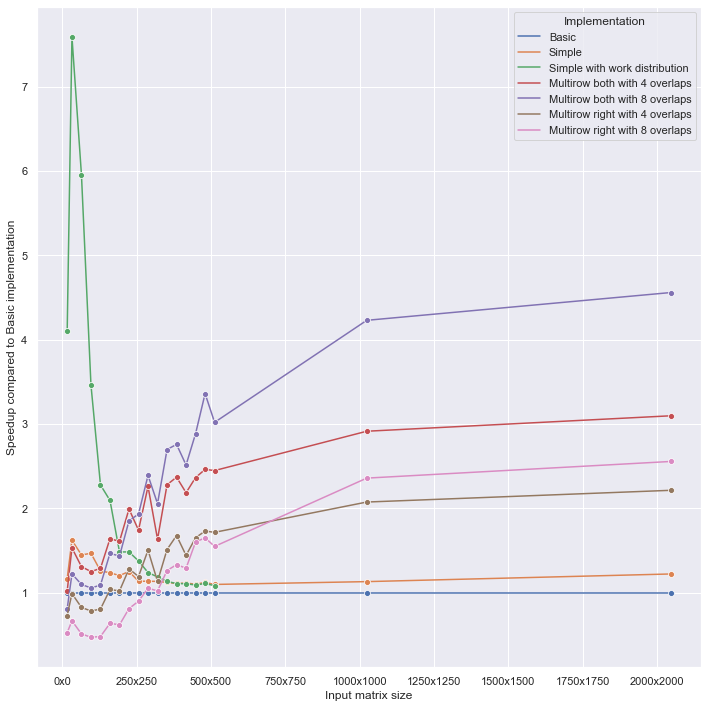

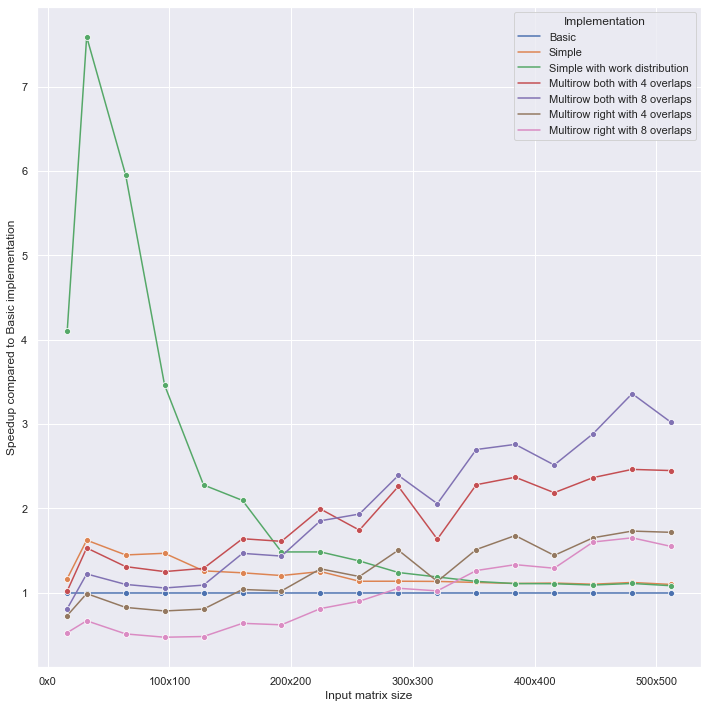

In [27]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "warp_shuffle_optimizations_speedup_gpulab")

group = benchmark.groups["one_to_one"]

comparison_base_name = "basic"
comparison_base_args = ""
warp_shuffle_algs_and_args = {
    "basic": {
        "": "Basic",
    },
    "nai_shuffle_multimat_right": {
        "": "Simple",
    },
    "nai_shuffle_multimat_right_work_distribution": {
        "": "Simple with work distribution",

    },
    "nai_shuffle_multirow_right": {
        "4": "Multirow right with 4 overlaps",
        "8": "Multirow right with 8 overlaps",
    },
    "nai_shuffle_multirow_both": {
        "4": "Multirow both with 4 overlaps",
        "8": "Multirow both with 8 overlaps"
    },
}

data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)

def filter_data(row) -> bool:
    return row["Name"] in warp_shuffle_algs_and_args and row["Args"] in warp_shuffle_algs_and_args[row["Name"]]

data = data[data[["Name", "Args"]].apply(filter_data, axis=1)]

grouped = data.groupby(["Name", "Args", "Input matrix rows"])



kernel_times = grouped["Kernel"].mean() / 1e9
kernel_times.name = "Kernel time"
results = kernel_times.reset_index()

comparison_base_times = results[(results["Name"] == comparison_base_name) & (results["Args"] == comparison_base_args)]

def speedup(row):
    min_time = comparison_base_times[comparison_base_times["Input matrix rows"] == row["Input matrix rows"]]["Kernel time"].item()
    return min_time / row["Kernel time"]

def map_name(row):
    return warp_shuffle_algs_and_args[row["Name"]][row["Args"]]

results["Speedup"] = results.apply(speedup, axis=1)
results["Implementation"] = results.apply(map_name, axis=1)


sns.set(rc={'figure.figsize': (10, 10)})
fig, ax = plt.subplots()

ax = sns.lineplot(data=results, x="Input matrix rows", y="Speedup", hue="Implementation", marker='o', ax=ax)
ticks = ax.get_xticks()
ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
ax.set_xticklabels(ticks)
ax.set_xlabel("Input matrix size")
ax.set_ylabel(f"Speedup compared to {warp_shuffle_algs_and_args[comparison_base_name][comparison_base_args]} implementation")
fig.tight_layout()
#fig.savefig("warp_shuffle_against_basic.svg", format="svg")

sns.set(rc={'figure.figsize': (10, 10)})
fig, ax = plt.subplots()

results = results[results["Input matrix rows"] <= 512 ]

ax = sns.lineplot(data=results, x="Input matrix rows", y="Speedup", hue="Implementation", marker='o', ax=ax)
ax.set_xticks(results["Input matrix rows"].unique())
ticks = ax.get_xticks()
ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
ax.set_xticklabels(ticks)
ax.set_xlabel("Input matrix size")
ax.set_ylabel(f"Speedup compared to {warp_shuffle_algs_and_args[comparison_base_name][comparison_base_args]} implementation")
fig.tight_layout()

# GPULAB ONE TO MANY

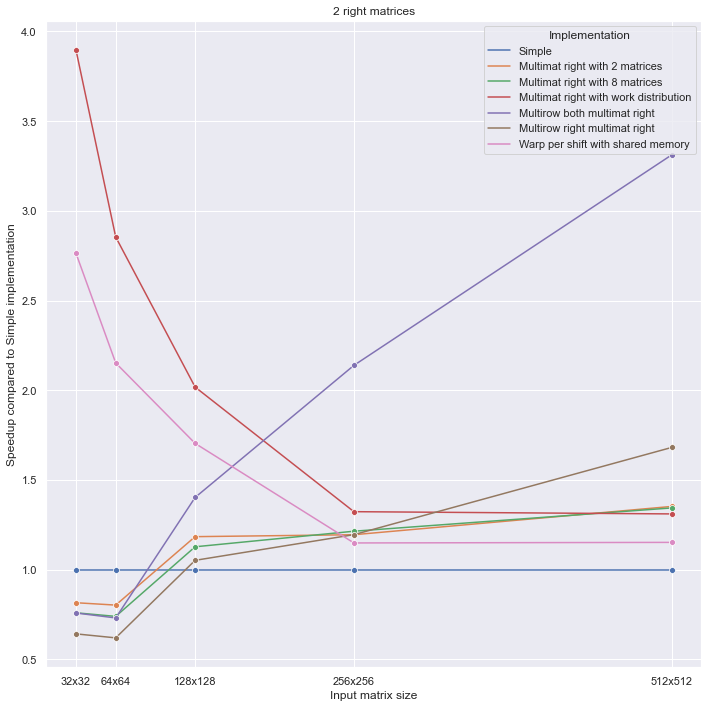

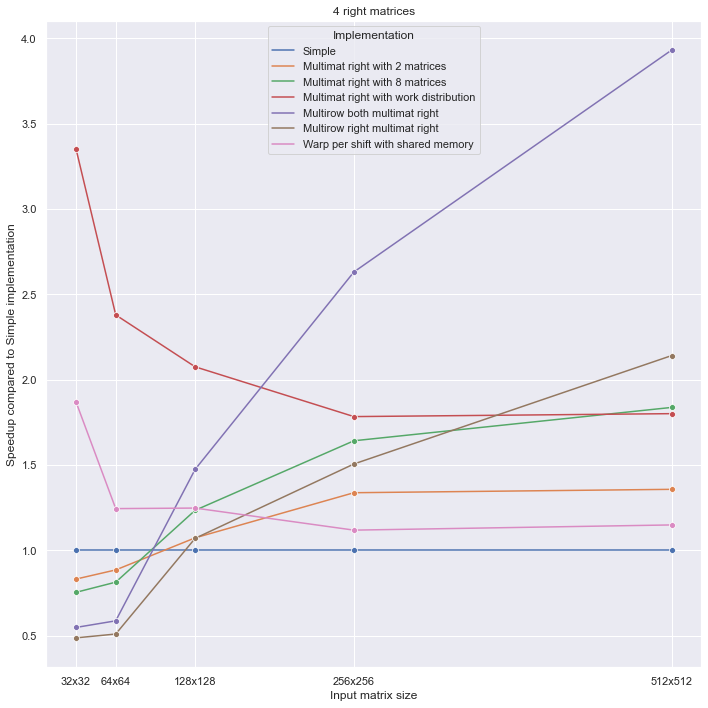

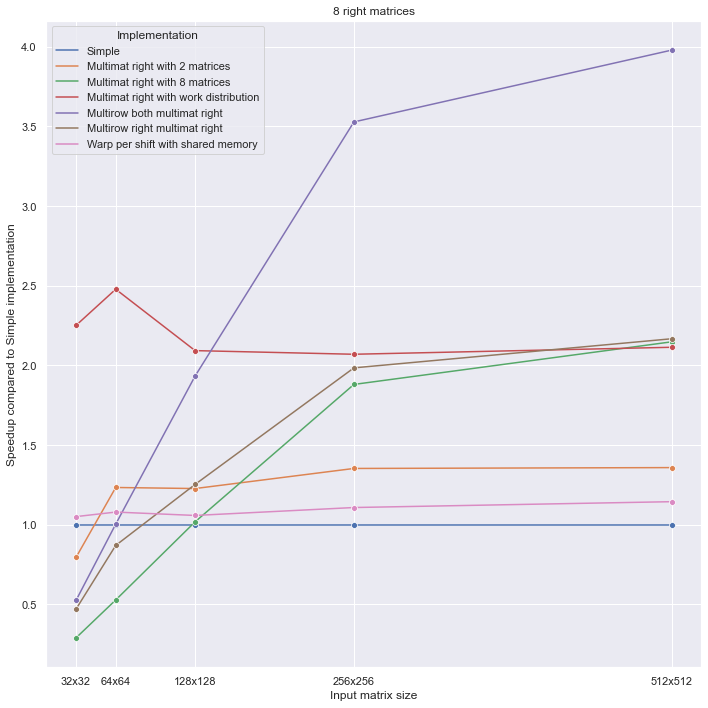

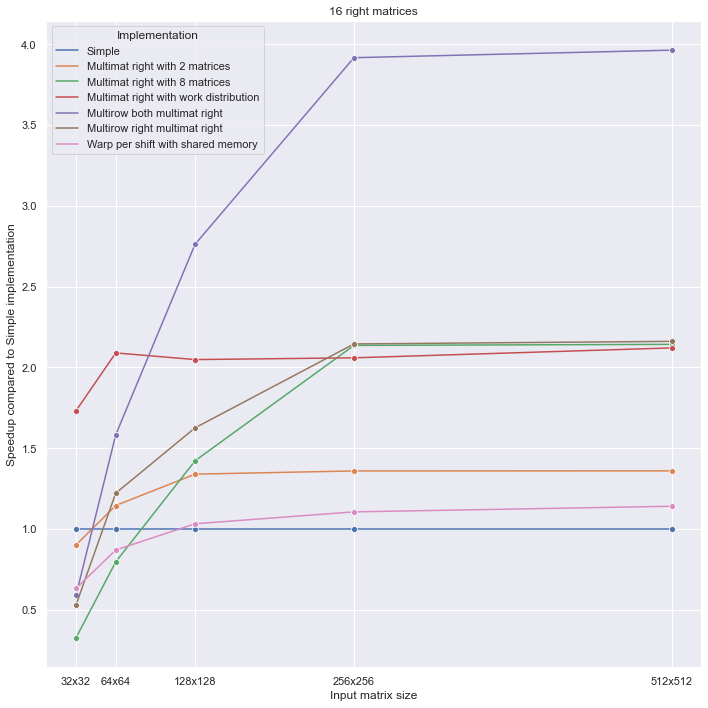

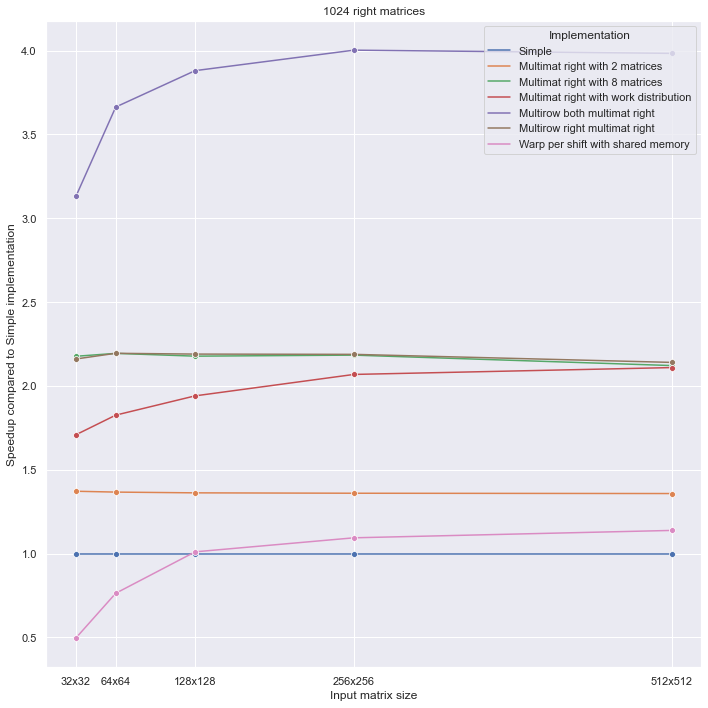

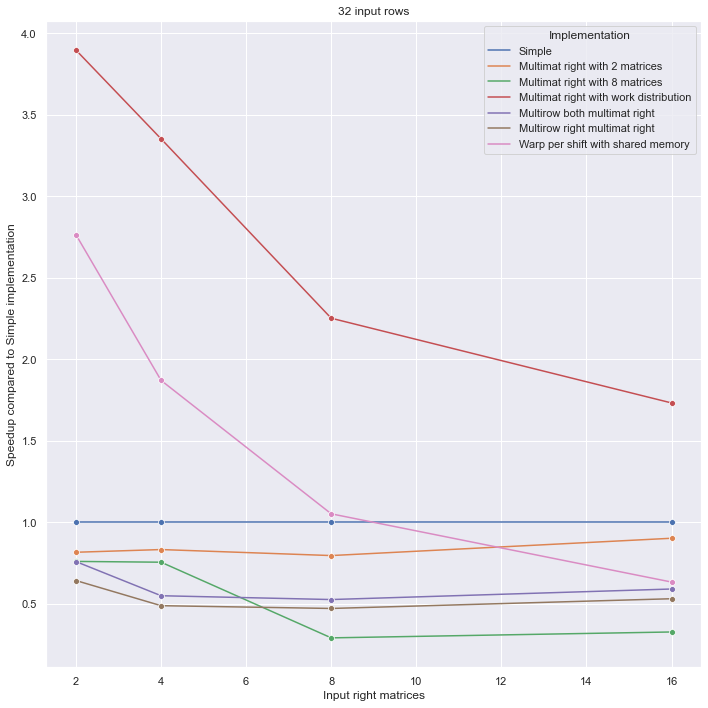

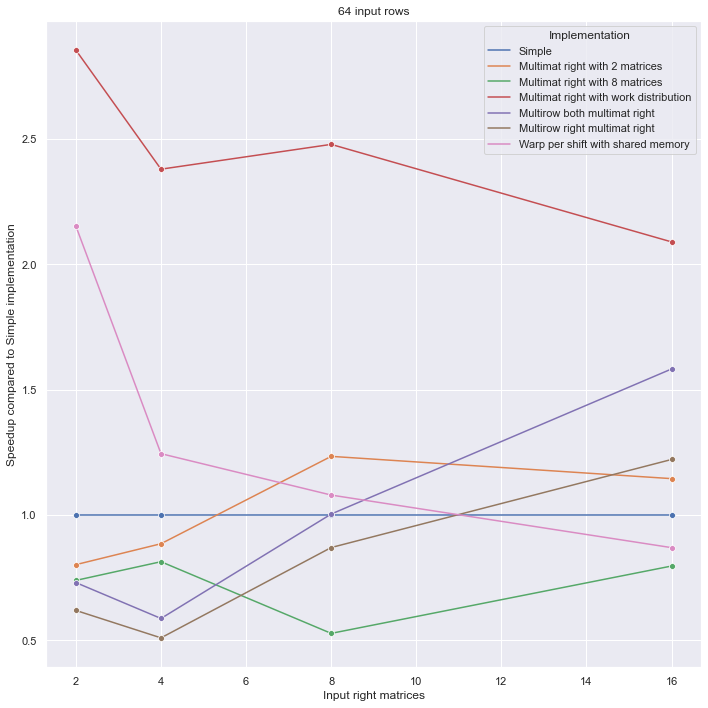

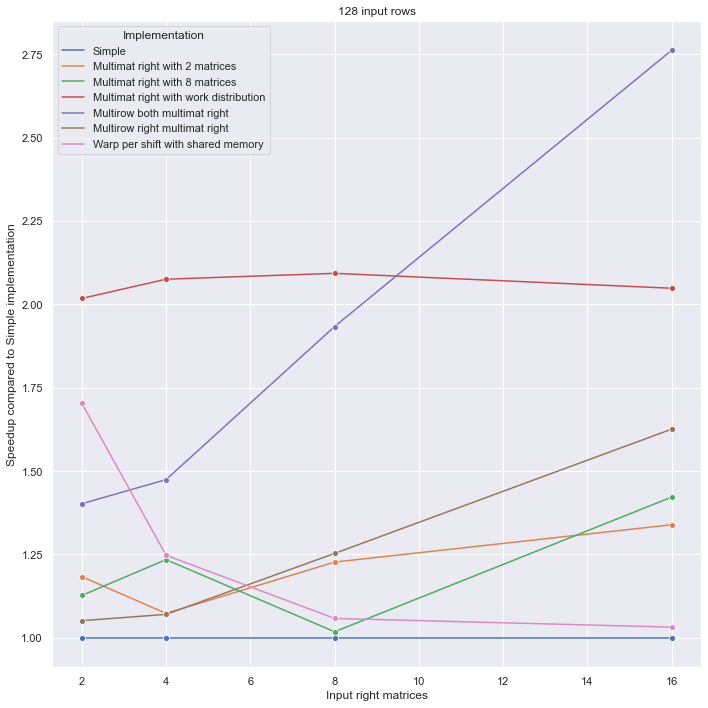

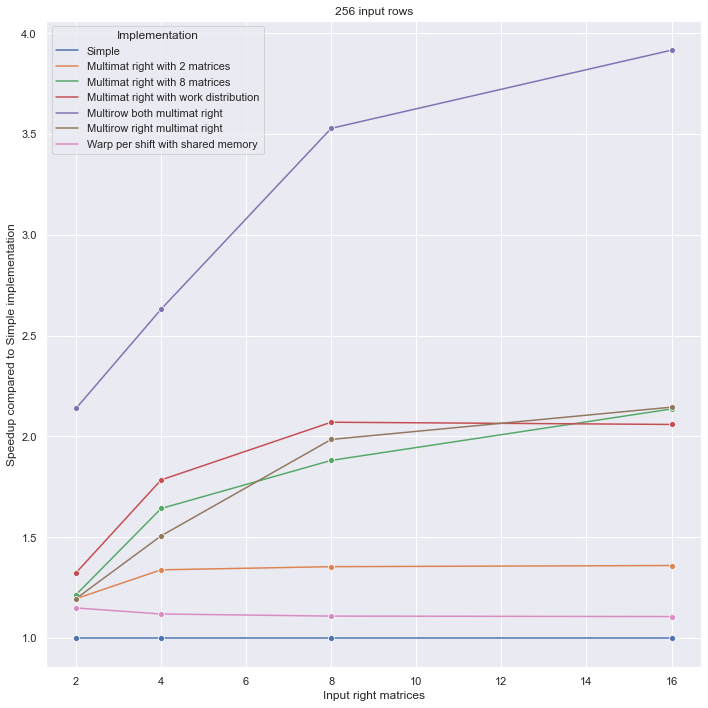

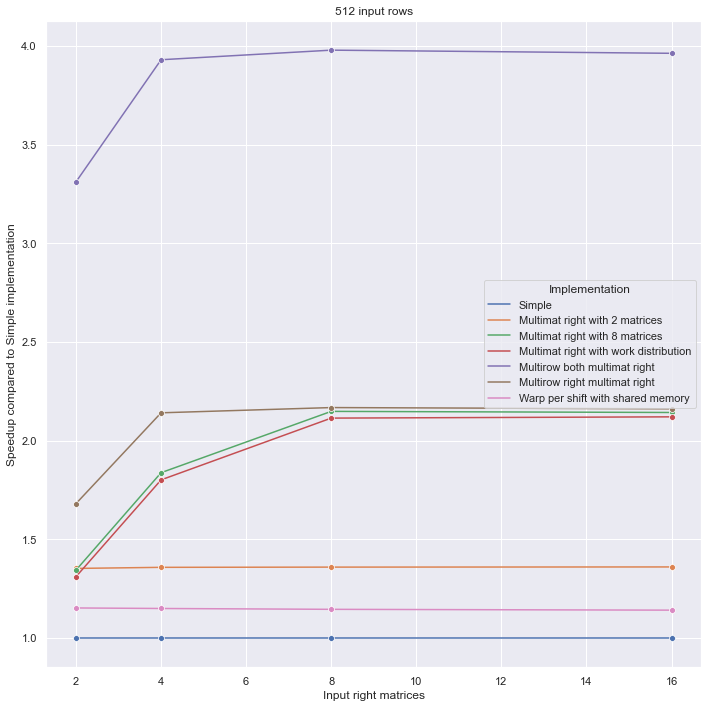

In [3]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "warp_shuffle_optimizations_speedup_gpulab")

group = benchmark.groups["one_to_many"]

comparison_base_name = "nai_shuffle_base"
comparison_base_args = ""
warp_shuffle_algs_and_args = {
    # "basic": {
    #     "": "Basic",
    # },
    "nai_shuffle_base": {
        "": "Simple",
    },
    "nai_shuffle_multimat_right": {
        "2": "Multimat right with 2 matrices",
        "8": "Multimat right with 8 matrices"
    },
    "nai_shuffle_multimat_right_work_distribution": {
        "": "Multimat right with work distribution"
    },
    "nai_shuffle_multirow_right_multimat_right": {
        "": "Multirow right multimat right"
    },
    "nai_shuffle_multirow_both_multimat_right": {
        "": "Multirow both multimat right"
    },
    "nai_warp_per_shift_shared_mem": {
        "": "Warp per shift with shared memory"
    },
}

data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)

def filter_data(row) -> bool:
    return row["Name"] in warp_shuffle_algs_and_args and row["Args"] in warp_shuffle_algs_and_args[row["Name"]]

data = data[data[["Name", "Args"]].apply(filter_data, axis=1)]

grouped = data.groupby(["Name", "Args", "Input right matrices", "Input matrix rows"])

kernel_times = grouped["Kernel"].mean() / 1e9
kernel_times.name = "Kernel time"
results = kernel_times.reset_index()

comparison_base_times = results[(results["Name"] == comparison_base_name) & (results["Args"] == comparison_base_args)]

def speedup(row):
    min_time = comparison_base_times[(comparison_base_times["Input right matrices"] == row["Input right matrices"]) & (comparison_base_times["Input matrix rows"] == row["Input matrix rows"])]["Kernel time"].item()
    return min_time / row["Kernel time"]

def map_name(row):
    return warp_shuffle_algs_and_args[row["Name"]][row["Args"]]

results["Speedup"] = results.apply(speedup, axis=1)
results["Implementation"] = results.apply(map_name, axis=1)

sns.set(rc={'figure.figsize': (10, 10)})

for right_matrices in sorted(results["Input right matrices"].unique()):
    fig, ax = plt.subplots()
    r_mat_results = results[results["Input right matrices"] == right_matrices]
    ax = sns.lineplot(data=r_mat_results, x="Input matrix rows", y="Speedup", hue="Implementation", marker='o', ax=ax)
    ax.set_xticks(results["Input matrix rows"].unique())
    ticks = ax.get_xticks()
    ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
    ax.set_xticklabels(ticks)
    ax.set_xlabel("Input matrix size")
    ax.set_ylabel(f"Speedup compared to {warp_shuffle_algs_and_args[comparison_base_name][comparison_base_args]} implementation")
    ax.set_title(f"{right_matrices} right matrices")
    fig.tight_layout()
    #fig.savefig("warp_shuffle_against_basic.svg", format="svg")

results = results[results["Input right matrices"] < 1024]

for input_rows in sorted(results["Input matrix rows"].unique()):
    sns.set(rc={'figure.figsize': (10, 10)})
    fig, ax = plt.subplots()
    r_row_results = results[results["Input matrix rows"] == input_rows]
    ax = sns.lineplot(data=r_row_results, x="Input right matrices", y="Speedup", hue="Implementation", marker='o', ax=ax)
    ax.set_xlabel("Input right matrices")
    ax.set_ylabel(f"Speedup compared to {warp_shuffle_algs_and_args[comparison_base_name][comparison_base_args]} implementation")
    ax.set_title(f"{input_rows} input rows")
    fig.tight_layout()

# GPULAB N TO MN

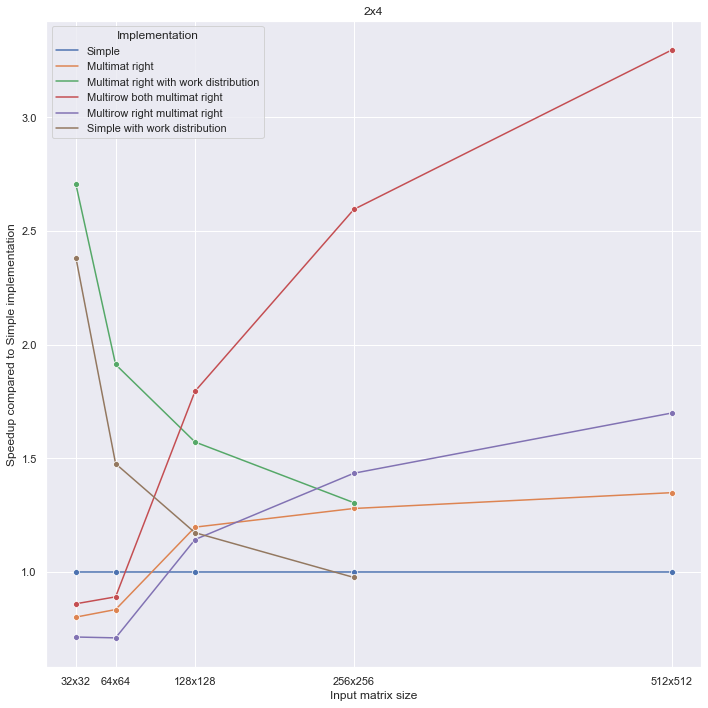

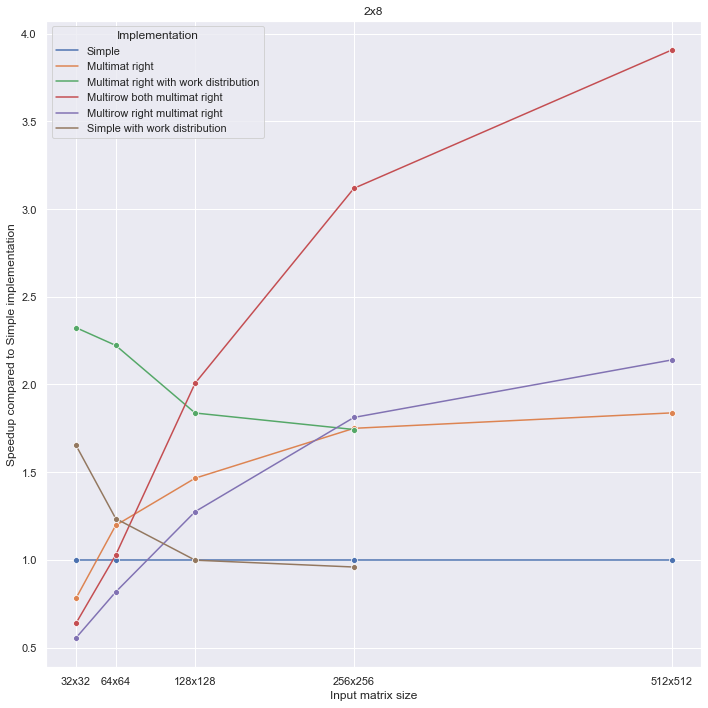

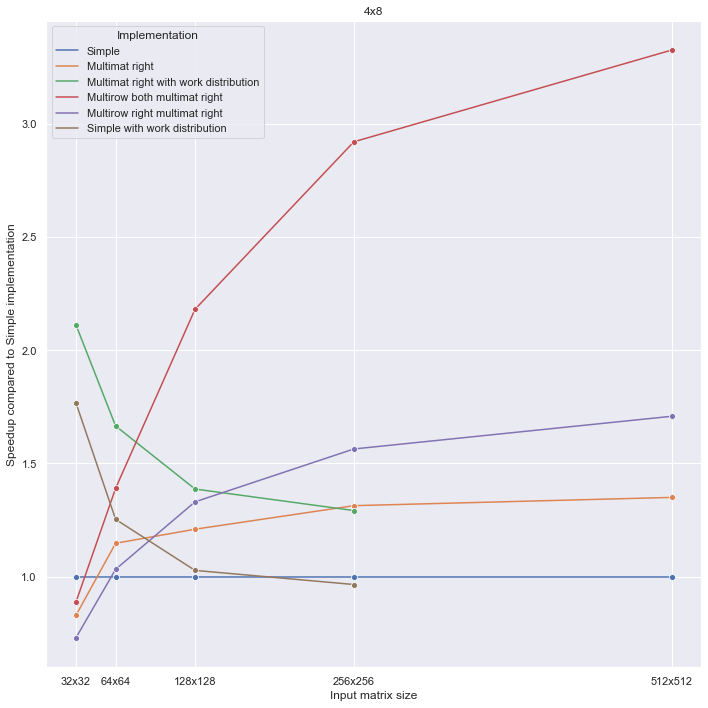

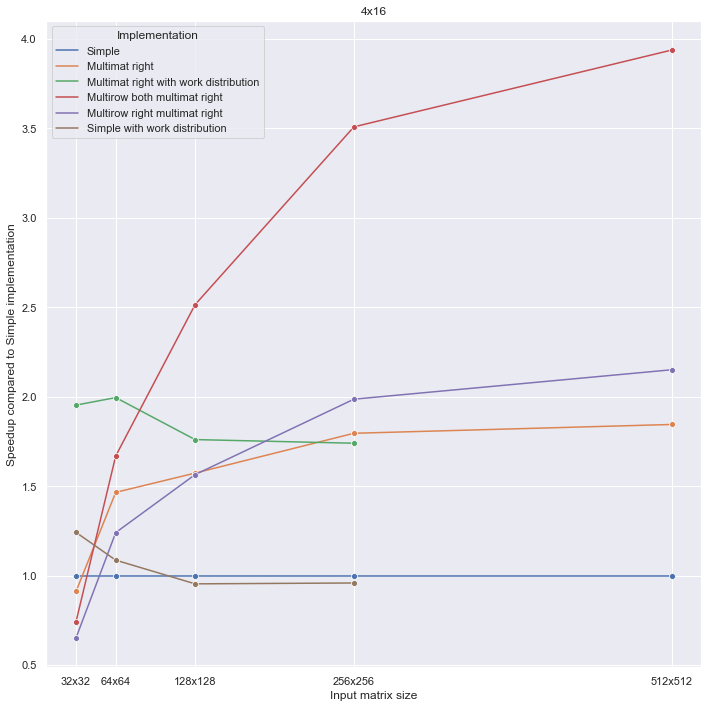

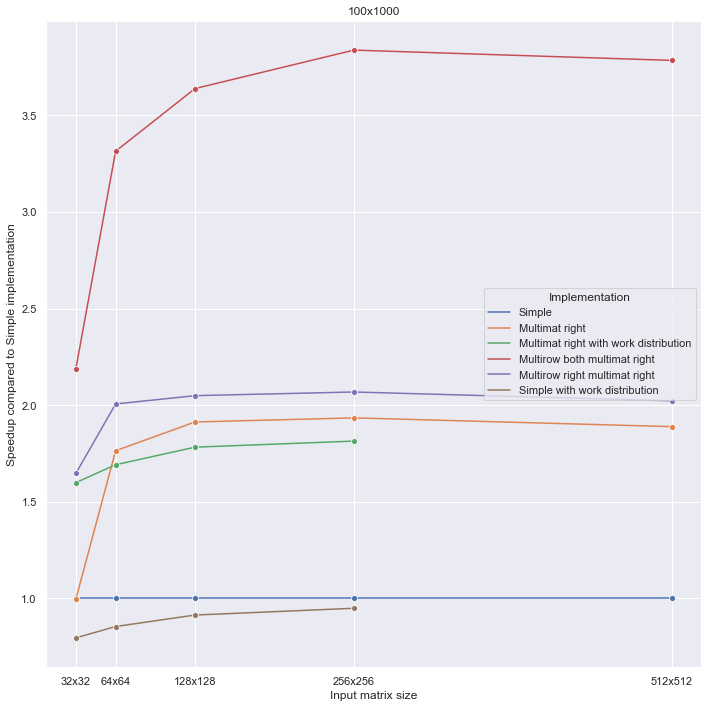

In [5]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "warp_shuffle_optimizations_speedup_gpulab")

group = benchmark.groups["n_to_mn"]

comparison_base_name = "nai_shuffle_base"
comparison_base_args = ""
warp_shuffle_algs_and_args = {
    # "basic": {
    #     "": "Basic",
    # },
    "nai_shuffle_base": {
        "": "Simple",
    },
    "nai_shuffle_work_distribution": {
        "": "Simple with work distribution"
    },
    "nai_shuffle_multimat_right": {
        "": "Multimat right"
    },
    "nai_shuffle_multimat_right_work_distribution": {
        "": "Multimat right with work distribution"
    },
    "nai_shuffle_multirow_right_multimat_right": {
        "": "Multirow right multimat right"
    },
    "nai_shuffle_multirow_both_multimat_right": {
        "": "Multirow both multimat right"
    },
    # "nai_warp_per_shift_shared_mem": {
    #     "": "Warp per shift with shared memory"
    # },
}

data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)

def filter_data(row) -> bool:
    return row["Name"] in warp_shuffle_algs_and_args and row["Args"] in warp_shuffle_algs_and_args[row["Name"]]

data = data[data[["Name", "Args"]].apply(filter_data, axis=1)]

grouped = data.groupby(["Name", "Args", "Input left matrices", "Input right matrices", "Input matrix rows"])

kernel_times = grouped["Kernel"].mean() / 1e9
kernel_times.name = "Kernel time"
results = kernel_times.reset_index()

comparison_base_times = results[(results["Name"] == comparison_base_name) & (results["Args"] == comparison_base_args)]

def speedup(row):
    min_time = comparison_base_times[(comparison_base_times["Input left matrices"] == row["Input left matrices"]) &(comparison_base_times["Input right matrices"] == row["Input right matrices"]) & (comparison_base_times["Input matrix rows"] == row["Input matrix rows"])]["Kernel time"].item()
    return min_time / row["Kernel time"]

def map_name(row):
    return warp_shuffle_algs_and_args[row["Name"]][row["Args"]]

results["Speedup"] = results.apply(speedup, axis=1)
results["Implementation"] = results.apply(map_name, axis=1)

sns.set(rc={'figure.figsize': (10, 10)})

for left_matrices in sorted(results["Input left matrices"].unique()):
    l_mat_results = results[results["Input left matrices"] == left_matrices]
    for right_matrices in sorted(l_mat_results["Input right matrices"].unique()):
        fig, ax = plt.subplots()
        r_mat_results = l_mat_results[l_mat_results["Input right matrices"] == right_matrices]
        ax = sns.lineplot(data=r_mat_results, x="Input matrix rows", y="Speedup", hue="Implementation", marker='o', ax=ax)
        ax.set_xticks(results["Input matrix rows"].unique())
        ticks = ax.get_xticks()
        ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
        ax.set_xticklabels(ticks)
        ax.set_xlabel("Input matrix size")
        ax.set_ylabel(f"Speedup compared to {warp_shuffle_algs_and_args[comparison_base_name][comparison_base_args]} implementation")
        ax.set_title(f"{left_matrices}x{right_matrices}")
        fig.tight_layout()
        #fig.savefig("warp_shuffle_against_basic.svg", format="svg")

# results = results[results["Input right matrices"] < 1024]

# for input_rows in sorted(results["Input matrix rows"].unique()):
#     sns.set(rc={'figure.figsize': (10, 10)})
#     fig, ax = plt.subplots()
#     r_row_results = results[results["Input matrix rows"] == input_rows]
#     ax = sns.lineplot(data=r_row_results, x="Input right matrices", y="Speedup", hue="Implementation", marker='o', ax=ax)
#     # ticks = ax.get_xticks()
#     # ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
#     # ax.set_xticklabels(ticks)
#     ax.set_xlabel("Input right matrices")
#     ax.set_ylabel(f"Speedup compared to {warp_shuffle_algs_and_args[comparison_base_name][comparison_base_args]} implementation")
#     ax.set_title(f"{input_rows} input rows")
#     fig.tight_layout()

# GPULAB N TO M

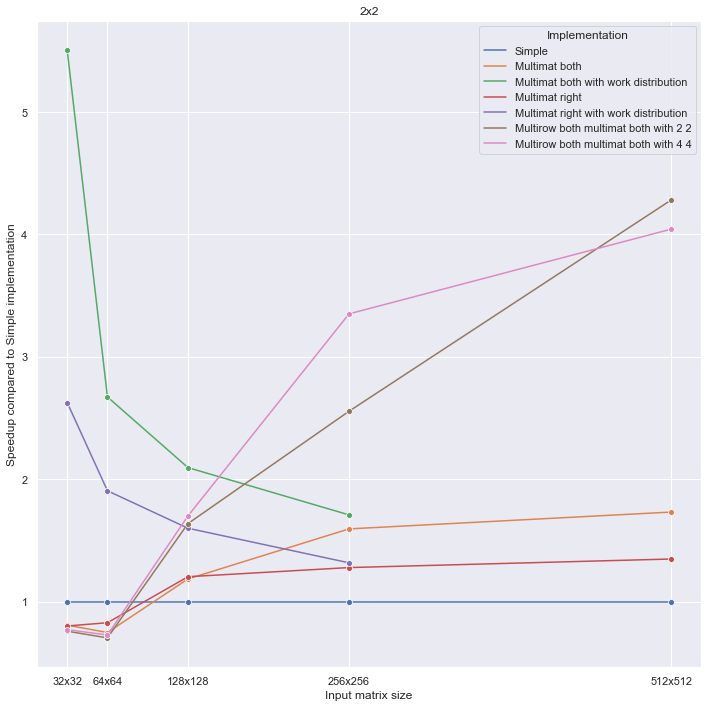

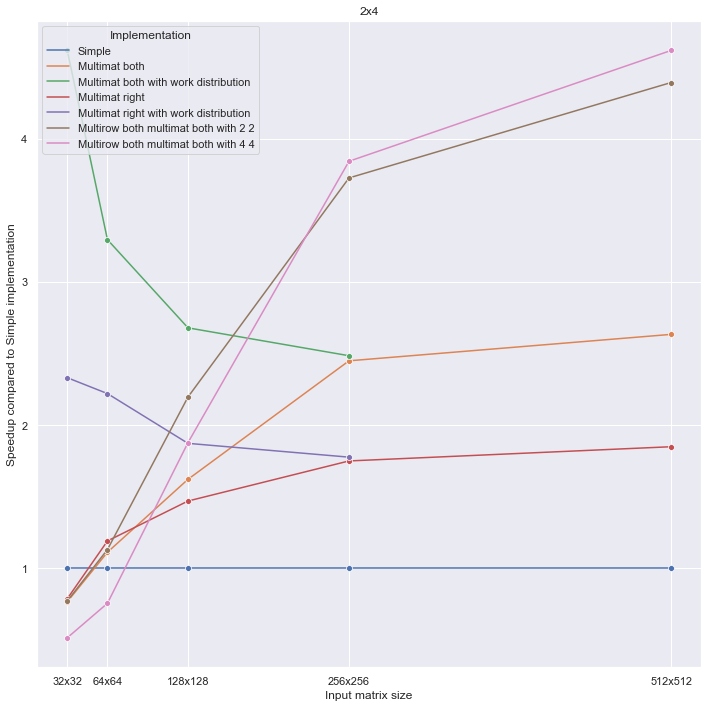

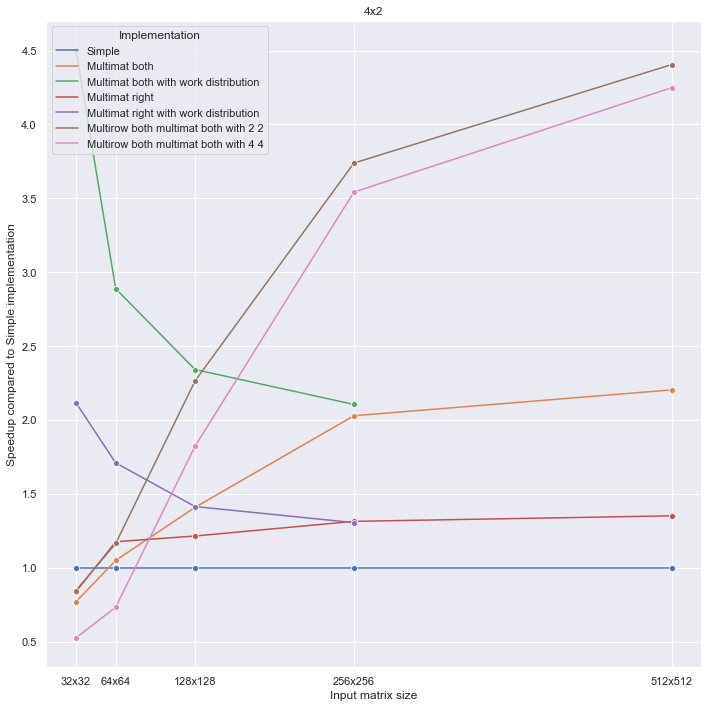

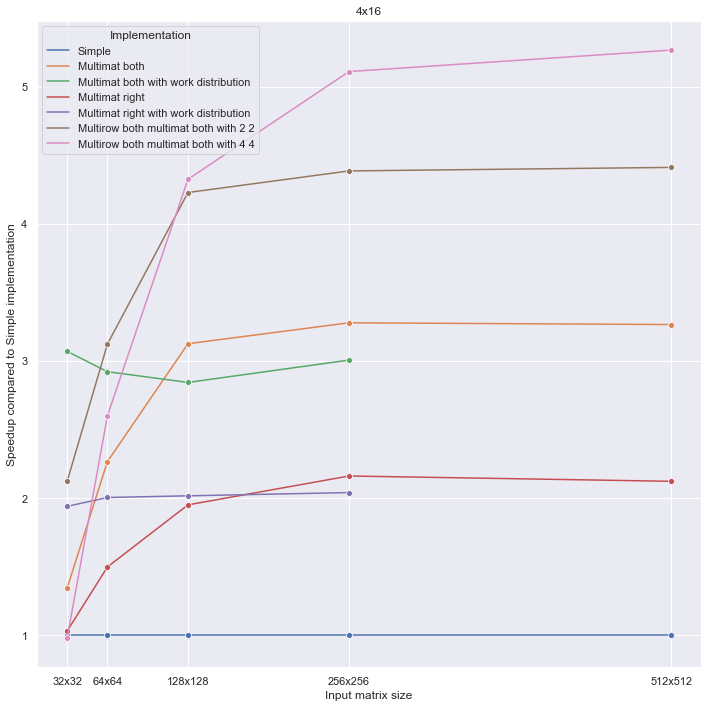

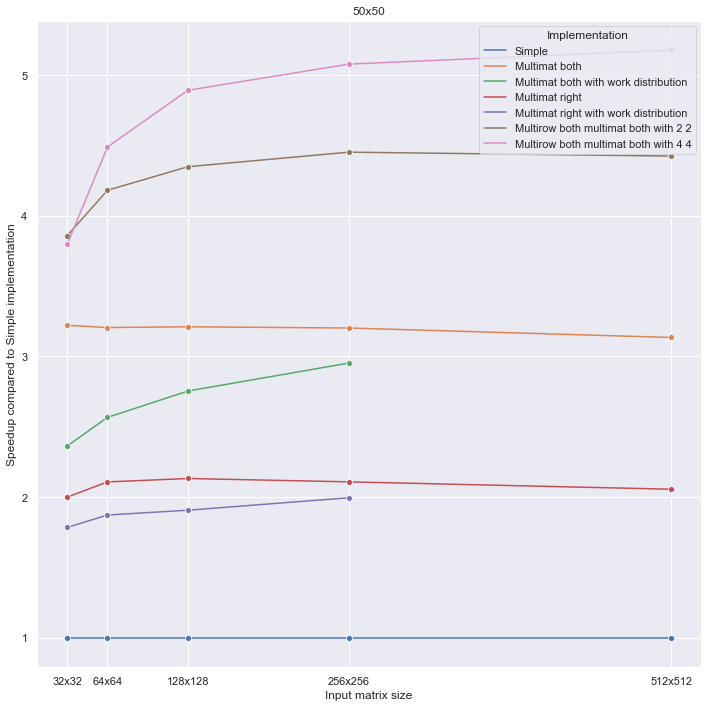

In [7]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "warp_shuffle_optimizations_speedup_gpulab")

group = benchmark.groups["n_to_m"]

comparison_base_name = "nai_shuffle_base"
comparison_base_args = ""
warp_shuffle_algs_and_args = {
    # "basic": {
    #     "": "Basic",
    # },
    "nai_shuffle_base": {
        "": "Simple",
    },
    "nai_shuffle_multimat_right": {
        "": "Multimat right"
    },
    "nai_shuffle_multimat_right_work_distribution": {
        "": "Multimat right with work distribution"
    },
    "nai_shuffle_multimat_both": {
        "": "Multimat both"
    },
    "nai_shuffle_multimat_both_work_distribution": {
        "": "Multimat both with work distribution"
    },
    "nai_shuffle_multirow_both_multimat_both": {
        "": "Multirow both multimat both with 2 2"
    },
    "nai_shuffle_multirow_both_multimat_both_large": {
        "": "Multirow both multimat both with 4 4"
    },
    # "nai_warp_per_shift_shared_mem": {
    #     "": "Warp per shift with shared memory"
    # },
}

data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)

def filter_data(row) -> bool:
    return row["Name"] in warp_shuffle_algs_and_args and row["Args"] in warp_shuffle_algs_and_args[row["Name"]]

data = data[data[["Name", "Args"]].apply(filter_data, axis=1)]

grouped = data.groupby(["Name", "Args", "Input left matrices", "Input right matrices", "Input matrix rows"])

kernel_times = grouped["Kernel"].mean() / 1e9
kernel_times.name = "Kernel time"
results = kernel_times.reset_index()

comparison_base_times = results[(results["Name"] == comparison_base_name) & (results["Args"] == comparison_base_args)]

def speedup(row):
    min_time = comparison_base_times[(comparison_base_times["Input left matrices"] == row["Input left matrices"]) &(comparison_base_times["Input right matrices"] == row["Input right matrices"]) & (comparison_base_times["Input matrix rows"] == row["Input matrix rows"])]["Kernel time"].item()
    return min_time / row["Kernel time"]

def map_name(row):
    return warp_shuffle_algs_and_args[row["Name"]][row["Args"]]

results["Speedup"] = results.apply(speedup, axis=1)
results["Implementation"] = results.apply(map_name, axis=1)

sns.set(rc={'figure.figsize': (10, 10)})

for left_matrices in sorted(results["Input left matrices"].unique()):
    l_mat_results = results[results["Input left matrices"] == left_matrices]
    for right_matrices in sorted(l_mat_results["Input right matrices"].unique()):
        fig, ax = plt.subplots()
        r_mat_results = l_mat_results[l_mat_results["Input right matrices"] == right_matrices]
        ax = sns.lineplot(data=r_mat_results, x="Input matrix rows", y="Speedup", hue="Implementation", marker='o', ax=ax)
        ax.set_xticks(results["Input matrix rows"].unique())
        ticks = ax.get_xticks()
        ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
        ax.set_xticklabels(ticks)
        ax.set_xlabel("Input matrix size")
        ax.set_ylabel(f"Speedup compared to {warp_shuffle_algs_and_args[comparison_base_name][comparison_base_args]} implementation")
        ax.set_title(f"{left_matrices}x{right_matrices}")
        fig.tight_layout()

# LAPTOP ONE TO ONE

/tmp/ipykernel_105464/2471344779.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks)
/tmp/ipykernel_105464/2471344779.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks)


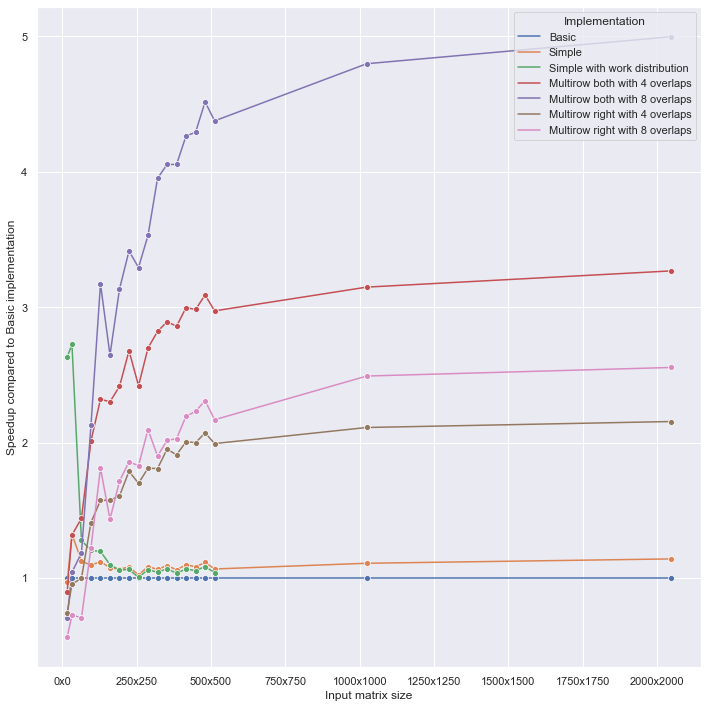

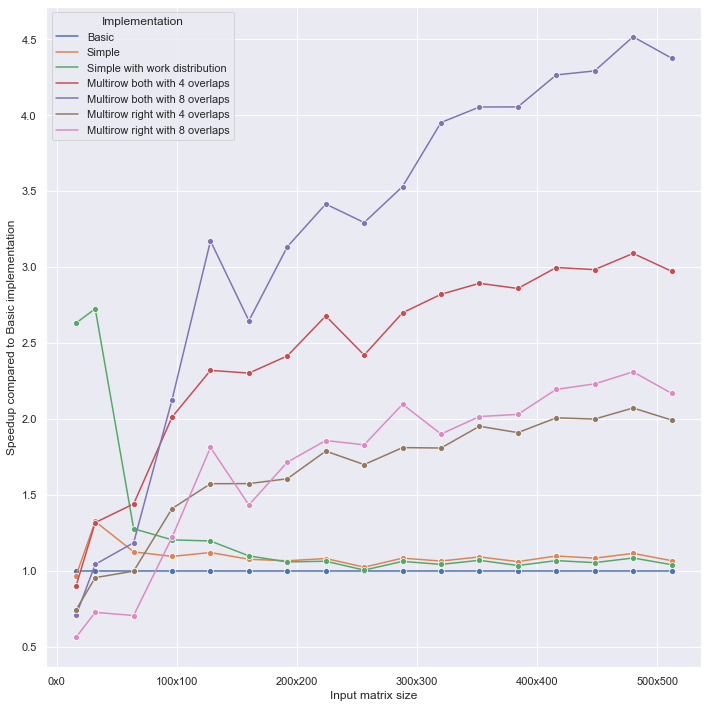

In [1]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "warp_shuffle_optimizations_speedup")

group = benchmark.groups["one_to_one"]

comparison_base_name = "basic"
comparison_base_args = ""
warp_shuffle_algs_and_args = {
    "basic": {
        "": "Basic",
    },
    "nai_shuffle_multimat_right": {
        "": "Simple",
    },
    "nai_shuffle_multimat_right_work_distribution": {
        "": "Simple with work distribution",

    },
    "nai_shuffle_multirow_right": {
        "4": "Multirow right with 4 overlaps",
        "8": "Multirow right with 8 overlaps",
    },
    "nai_shuffle_multirow_both": {
        "4": "Multirow both with 4 overlaps",
        "8": "Multirow both with 8 overlaps"
    },
}

data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)

def filter_data(row) -> bool:
    return row["Name"] in warp_shuffle_algs_and_args and row["Args"] in warp_shuffle_algs_and_args[row["Name"]]

data = data[data[["Name", "Args"]].apply(filter_data, axis=1)]

grouped = data.groupby(["Name", "Args", "Input matrix rows"])



kernel_times = grouped["Kernel"].mean() / 1e9
kernel_times.name = "Kernel time"
results = kernel_times.reset_index()

comparison_base_times = results[(results["Name"] == comparison_base_name) & (results["Args"] == comparison_base_args)]

def speedup(row):
    min_time = comparison_base_times[comparison_base_times["Input matrix rows"] == row["Input matrix rows"]]["Kernel time"].item()
    return min_time / row["Kernel time"]

def map_name(row):
    return warp_shuffle_algs_and_args[row["Name"]][row["Args"]]

results["Speedup"] = results.apply(speedup, axis=1)
results["Implementation"] = results.apply(map_name, axis=1)


sns.set(rc={'figure.figsize': (10, 10)})
fig, ax = plt.subplots()

ax = sns.lineplot(data=results, x="Input matrix rows", y="Speedup", hue="Implementation", marker='o', ax=ax)
ticks = ax.get_xticks()
ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
ax.set_xticklabels(ticks)
ax.set_xlabel("Input matrix size")
ax.set_ylabel(f"Speedup compared to {warp_shuffle_algs_and_args[comparison_base_name][comparison_base_args]} implementation")
fig.tight_layout()
#fig.savefig("warp_shuffle_against_basic.svg", format="svg")

sns.set(rc={'figure.figsize': (10, 10)})
fig, ax = plt.subplots()

results = results[results["Input matrix rows"] <= 512 ]

ax = sns.lineplot(data=results, x="Input matrix rows", y="Speedup", hue="Implementation", marker='o', ax=ax)
ax.set_xticks(results["Input matrix rows"].unique())
ticks = ax.get_xticks()
ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
ax.set_xticklabels(ticks)
ax.set_xlabel("Input matrix size")
ax.set_ylabel(f"Speedup compared to {warp_shuffle_algs_and_args[comparison_base_name][comparison_base_args]} implementation")
fig.tight_layout()

# LAPTOP ONE TO MANY

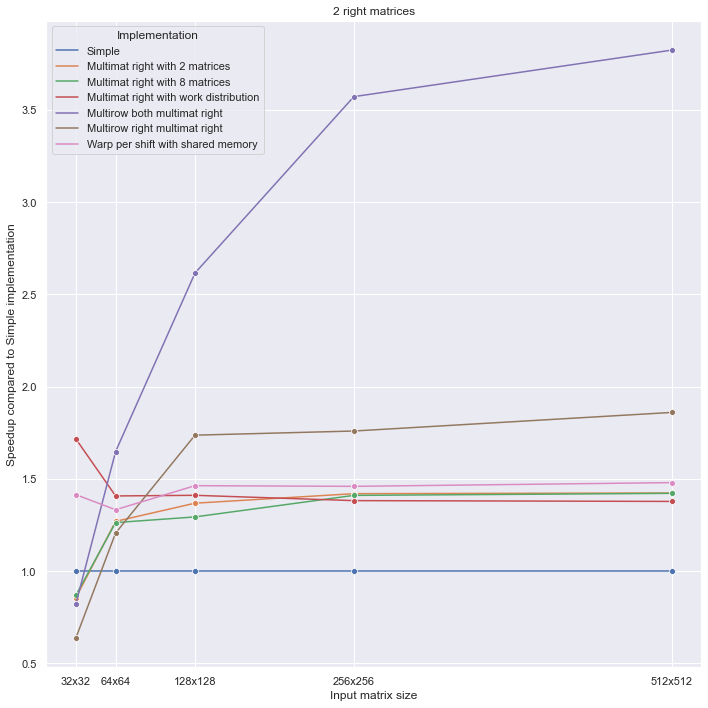

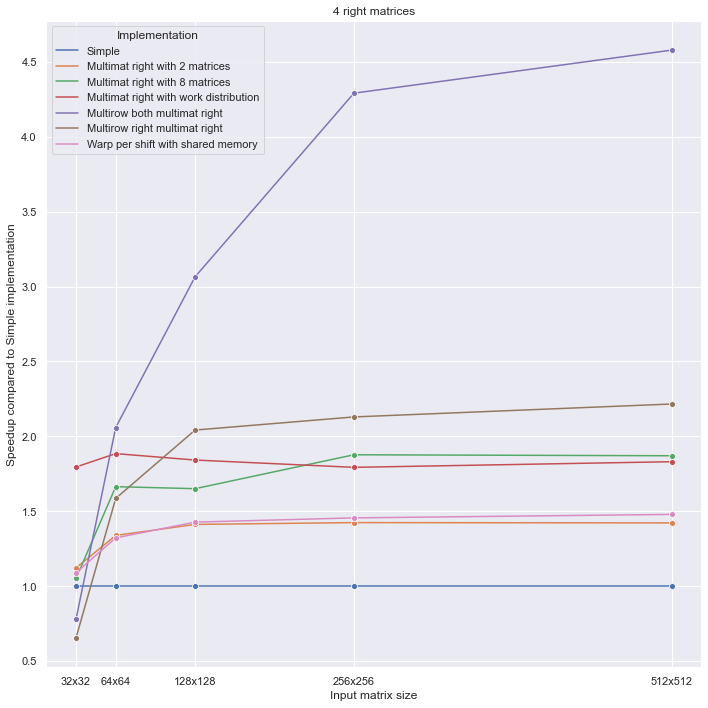

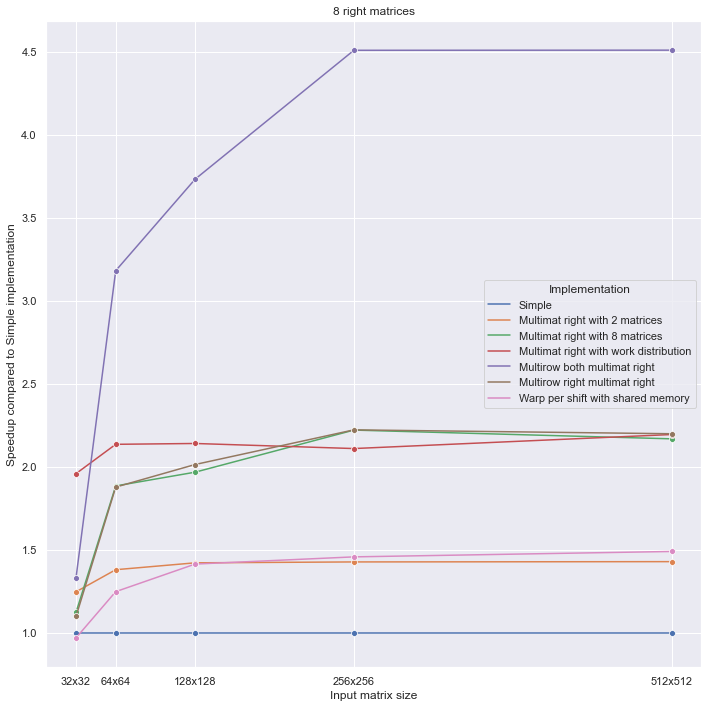

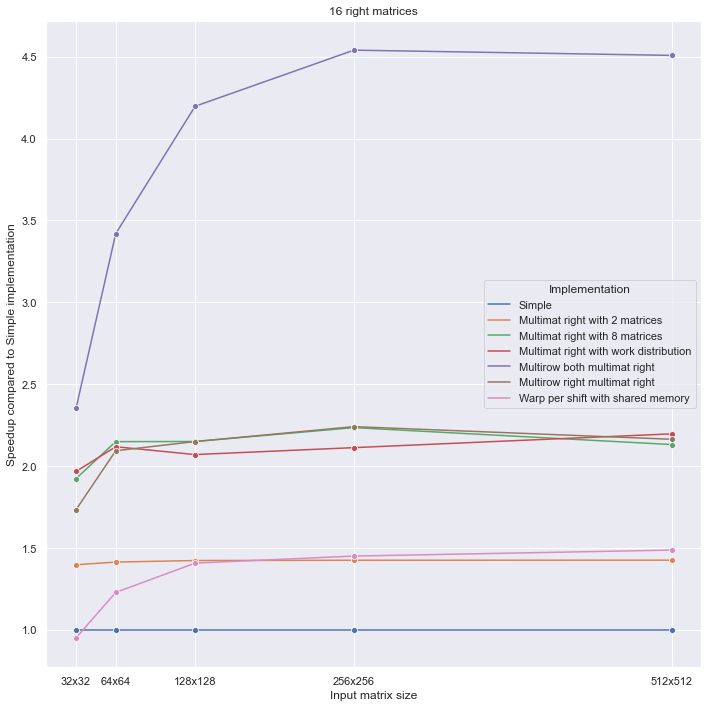

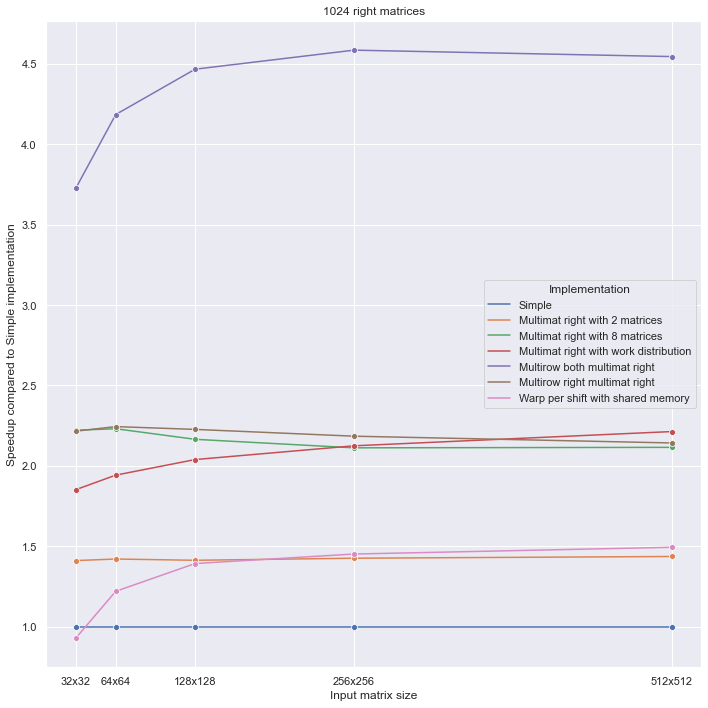

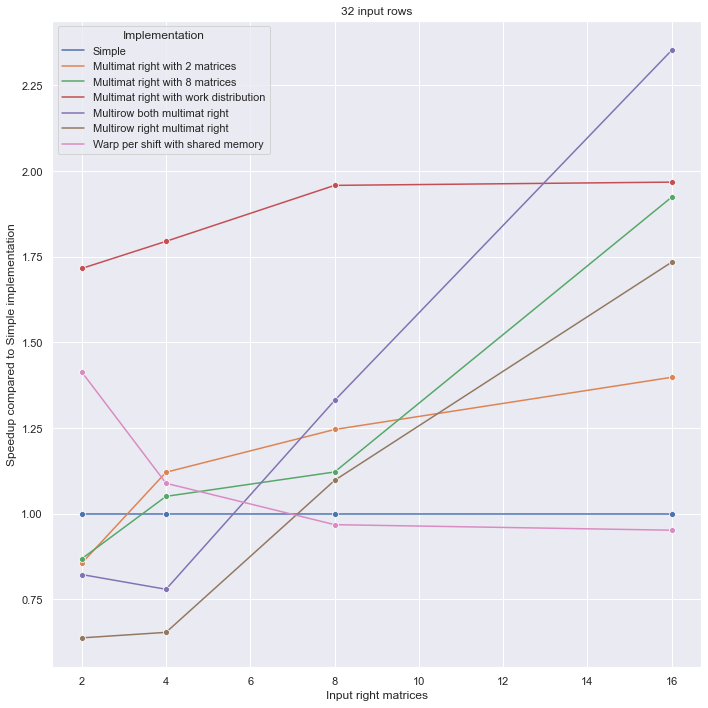

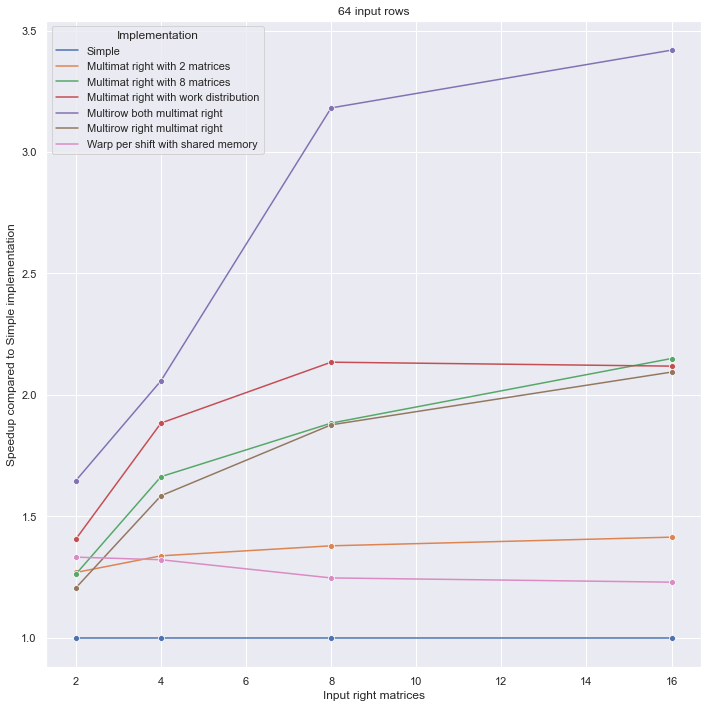

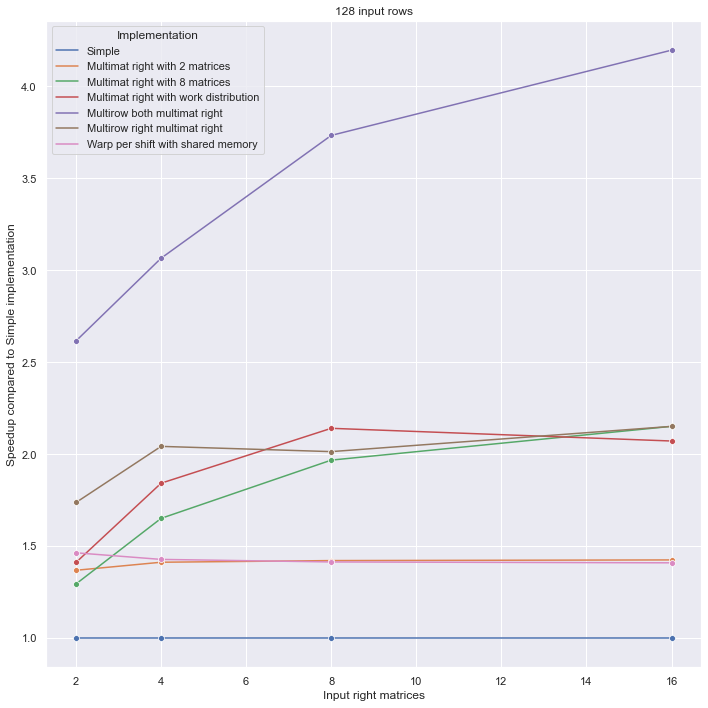

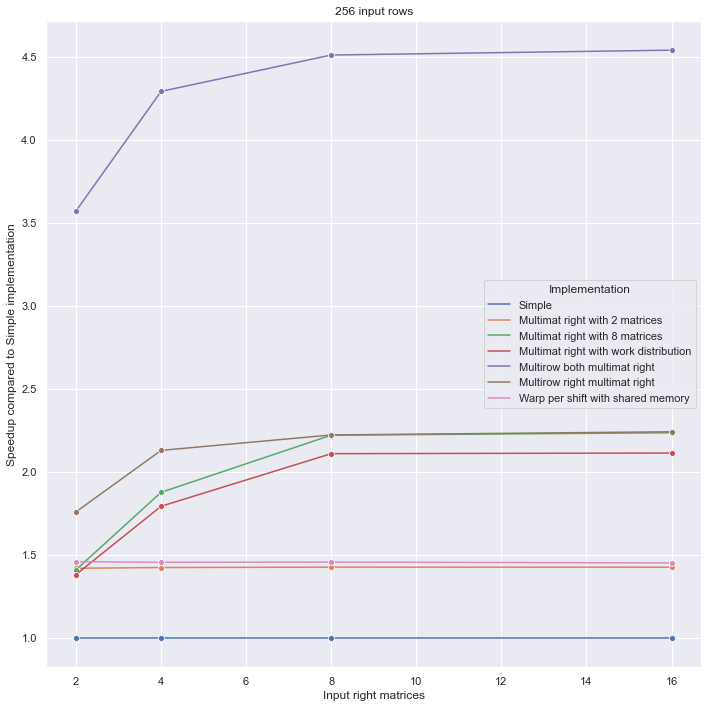

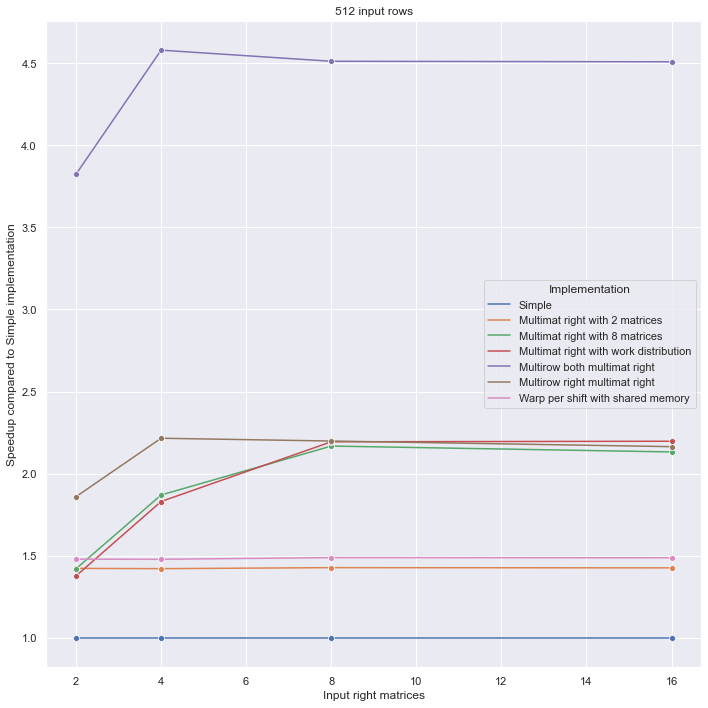

In [2]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "warp_shuffle_optimizations_speedup")

group = benchmark.groups["one_to_many"]

comparison_base_name = "nai_shuffle_base"
comparison_base_args = ""
warp_shuffle_algs_and_args = {
    # "basic": {
    #     "": "Basic",
    # },
    "nai_shuffle_base": {
        "": "Simple",
    },
    "nai_shuffle_multimat_right": {
        "2": "Multimat right with 2 matrices",
        "8": "Multimat right with 8 matrices"
    },
    "nai_shuffle_multimat_right_work_distribution": {
        "": "Multimat right with work distribution"
    },
    "nai_shuffle_multirow_right_multimat_right": {
        "": "Multirow right multimat right"
    },
    "nai_shuffle_multirow_both_multimat_right": {
        "": "Multirow both multimat right"
    },
    "nai_warp_per_shift_shared_mem": {
        "": "Warp per shift with shared memory"
    },
}

data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)

def filter_data(row) -> bool:
    return row["Name"] in warp_shuffle_algs_and_args and row["Args"] in warp_shuffle_algs_and_args[row["Name"]]

data = data[data[["Name", "Args"]].apply(filter_data, axis=1)]

grouped = data.groupby(["Name", "Args", "Input right matrices", "Input matrix rows"])

kernel_times = grouped["Kernel"].mean() / 1e9
kernel_times.name = "Kernel time"
results = kernel_times.reset_index()

comparison_base_times = results[(results["Name"] == comparison_base_name) & (results["Args"] == comparison_base_args)]

def speedup(row):
    min_time = comparison_base_times[(comparison_base_times["Input right matrices"] == row["Input right matrices"]) & (comparison_base_times["Input matrix rows"] == row["Input matrix rows"])]["Kernel time"].item()
    return min_time / row["Kernel time"]

def map_name(row):
    return warp_shuffle_algs_and_args[row["Name"]][row["Args"]]

results["Speedup"] = results.apply(speedup, axis=1)
results["Implementation"] = results.apply(map_name, axis=1)

sns.set(rc={'figure.figsize': (10, 10)})

for right_matrices in sorted(results["Input right matrices"].unique()):
    fig, ax = plt.subplots()
    r_mat_results = results[results["Input right matrices"] == right_matrices]
    ax = sns.lineplot(data=r_mat_results, x="Input matrix rows", y="Speedup", hue="Implementation", marker='o', ax=ax)
    ax.set_xticks(results["Input matrix rows"].unique())
    ticks = ax.get_xticks()
    ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
    ax.set_xticklabels(ticks)
    ax.set_xlabel("Input matrix size")
    ax.set_ylabel(f"Speedup compared to {warp_shuffle_algs_and_args[comparison_base_name][comparison_base_args]} implementation")
    ax.set_title(f"{right_matrices} right matrices")
    fig.tight_layout()
    #fig.savefig("warp_shuffle_against_basic.svg", format="svg")

results = results[results["Input right matrices"] < 1024]

for input_rows in sorted(results["Input matrix rows"].unique()):
    sns.set(rc={'figure.figsize': (10, 10)})
    fig, ax = plt.subplots()
    r_row_results = results[results["Input matrix rows"] == input_rows]
    ax = sns.lineplot(data=r_row_results, x="Input right matrices", y="Speedup", hue="Implementation", marker='o', ax=ax)
    ax.set_xlabel("Input right matrices")
    ax.set_ylabel(f"Speedup compared to {warp_shuffle_algs_and_args[comparison_base_name][comparison_base_args]} implementation")
    ax.set_title(f"{input_rows} input rows")
    fig.tight_layout()

# LAPTOP N TO MN

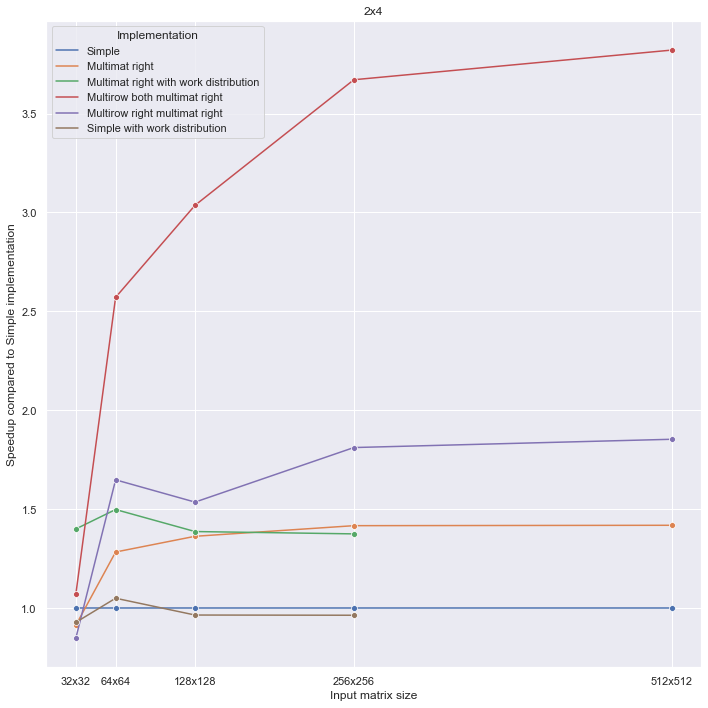

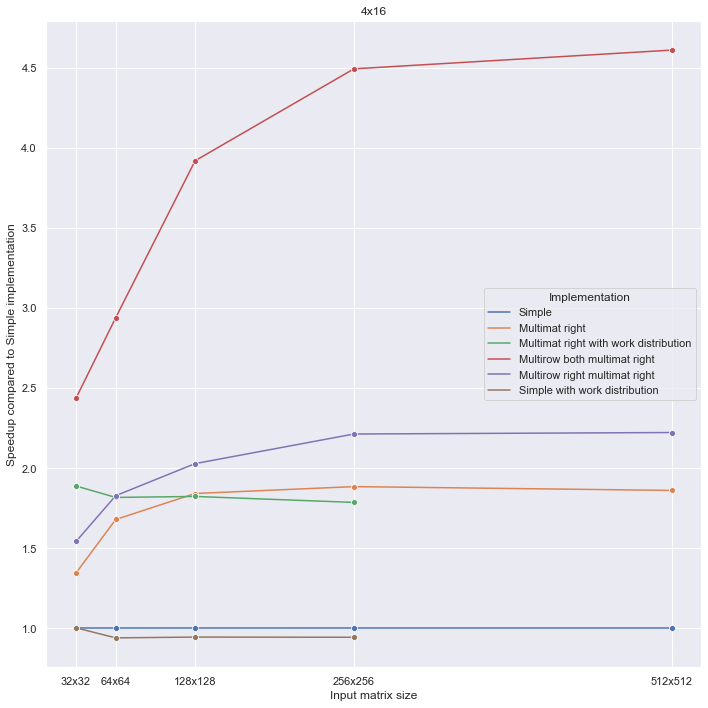

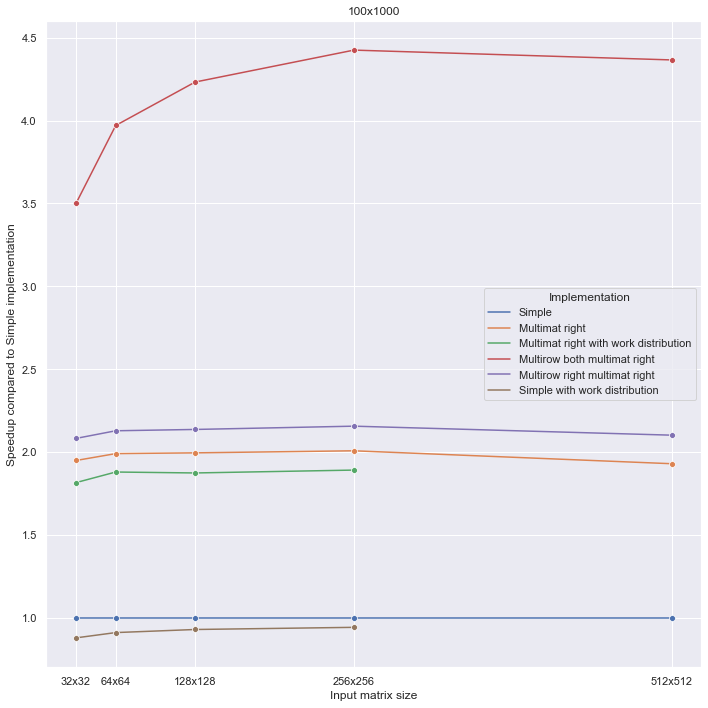

In [6]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "warp_shuffle_optimizations_speedup")

group = benchmark.groups["n_to_mn"]

comparison_base_name = "nai_shuffle_base"
comparison_base_args = ""
warp_shuffle_algs_and_args = {
    # "basic": {
    #     "": "Basic",
    # },
    "nai_shuffle_base": {
        "": "Simple",
    },
    "nai_shuffle_work_distribution": {
        "": "Simple with work distribution"
    },
    "nai_shuffle_multimat_right": {
        "": "Multimat right"
    },
    "nai_shuffle_multimat_right_work_distribution": {
        "": "Multimat right with work distribution"
    },
    "nai_shuffle_multirow_right_multimat_right": {
        "": "Multirow right multimat right"
    },
    "nai_shuffle_multirow_both_multimat_right": {
        "": "Multirow both multimat right"
    },
    # "nai_warp_per_shift_shared_mem": {
    #     "": "Warp per shift with shared memory"
    # },
}

data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)

def filter_data(row) -> bool:
    return row["Name"] in warp_shuffle_algs_and_args and row["Args"] in warp_shuffle_algs_and_args[row["Name"]]

data = data[data[["Name", "Args"]].apply(filter_data, axis=1)]

grouped = data.groupby(["Name", "Args", "Input left matrices", "Input right matrices", "Input matrix rows"])

kernel_times = grouped["Kernel"].mean() / 1e9
kernel_times.name = "Kernel time"
results = kernel_times.reset_index()

comparison_base_times = results[(results["Name"] == comparison_base_name) & (results["Args"] == comparison_base_args)]

def speedup(row):
    min_time = comparison_base_times[(comparison_base_times["Input left matrices"] == row["Input left matrices"]) &(comparison_base_times["Input right matrices"] == row["Input right matrices"]) & (comparison_base_times["Input matrix rows"] == row["Input matrix rows"])]["Kernel time"].item()
    return min_time / row["Kernel time"]

def map_name(row):
    return warp_shuffle_algs_and_args[row["Name"]][row["Args"]]

results["Speedup"] = results.apply(speedup, axis=1)
results["Implementation"] = results.apply(map_name, axis=1)

sns.set(rc={'figure.figsize': (10, 10)})

for left_matrices in sorted(results["Input left matrices"].unique()):
    l_mat_results = results[results["Input left matrices"] == left_matrices]
    for right_matrices in sorted(l_mat_results["Input right matrices"].unique()):
        fig, ax = plt.subplots()
        r_mat_results = l_mat_results[l_mat_results["Input right matrices"] == right_matrices]
        ax = sns.lineplot(data=r_mat_results, x="Input matrix rows", y="Speedup", hue="Implementation", marker='o', ax=ax)
        ax.set_xticks(results["Input matrix rows"].unique())
        ticks = ax.get_xticks()
        ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
        ax.set_xticklabels(ticks)
        ax.set_xlabel("Input matrix size")
        ax.set_ylabel(f"Speedup compared to {warp_shuffle_algs_and_args[comparison_base_name][comparison_base_args]} implementation")
        ax.set_title(f"{left_matrices}x{right_matrices}")
        fig.tight_layout()
        #fig.savefig("warp_shuffle_against_basic.svg", format="svg")

# results = results[results["Input right matrices"] < 1024]

# for input_rows in sorted(results["Input matrix rows"].unique()):
#     sns.set(rc={'figure.figsize': (10, 10)})
#     fig, ax = plt.subplots()
#     r_row_results = results[results["Input matrix rows"] == input_rows]
#     ax = sns.lineplot(data=r_row_results, x="Input right matrices", y="Speedup", hue="Implementation", marker='o', ax=ax)
#     # ticks = ax.get_xticks()
#     # ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
#     # ax.set_xticklabels(ticks)
#     ax.set_xlabel("Input right matrices")
#     ax.set_ylabel(f"Speedup compared to {warp_shuffle_algs_and_args[comparison_base_name][comparison_base_args]} implementation")
#     ax.set_title(f"{input_rows} input rows")
#     fig.tight_layout()

# LAPTOP N TO M

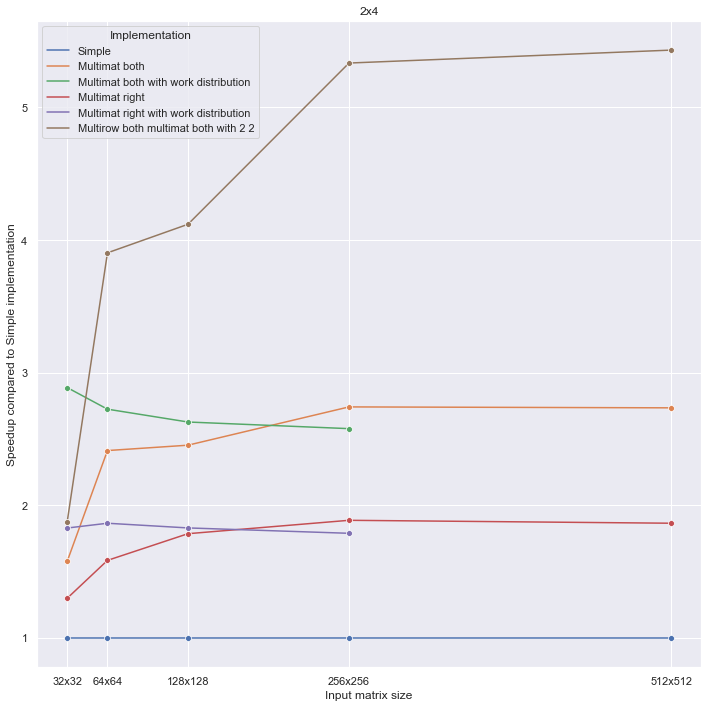

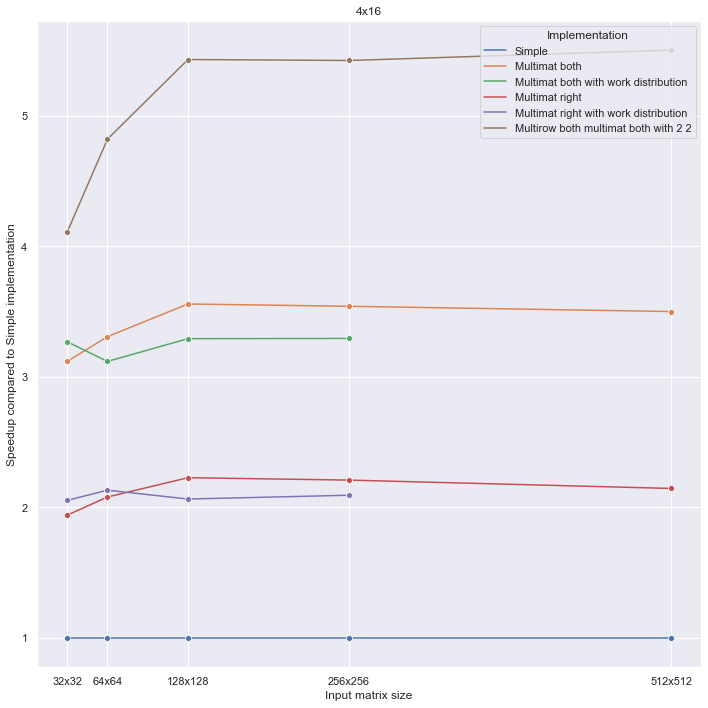

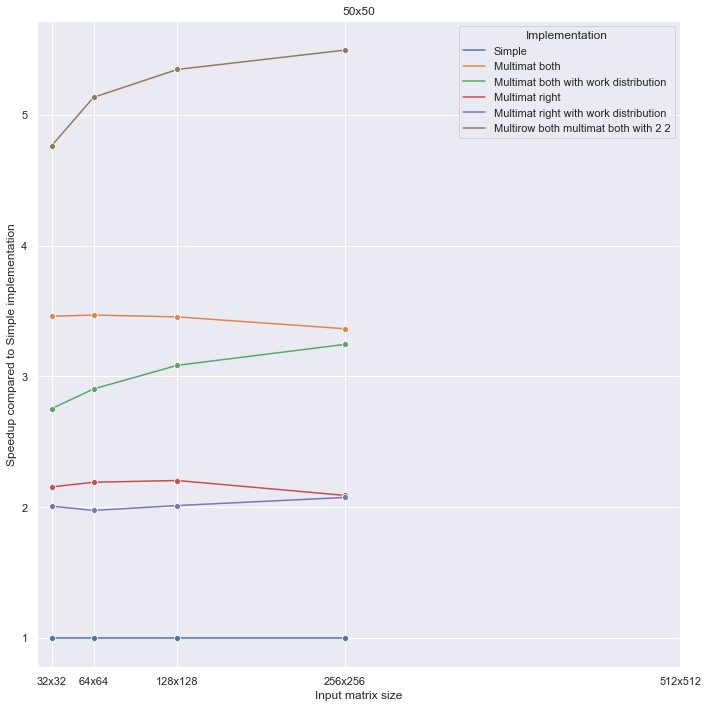

In [8]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "warp_shuffle_optimizations_speedup")

group = benchmark.groups["n_to_m"]

comparison_base_name = "nai_shuffle_base"
comparison_base_args = ""
warp_shuffle_algs_and_args = {
    # "basic": {
    #     "": "Basic",
    # },
    "nai_shuffle_base": {
        "": "Simple",
    },
    "nai_shuffle_multimat_right": {
        "": "Multimat right"
    },
    "nai_shuffle_multimat_right_work_distribution": {
        "": "Multimat right with work distribution"
    },
    "nai_shuffle_multimat_both": {
        "": "Multimat both"
    },
    "nai_shuffle_multimat_both_work_distribution": {
        "": "Multimat both with work distribution"
    },
    "nai_shuffle_multirow_both_multimat_both": {
        "": "Multirow both multimat both with 2 2"
    },
    "nai_shuffle_multirow_both_multimat_both_large": {
        "": "Multirow both multimat both with 4 4"
    },
    # "nai_warp_per_shift_shared_mem": {
    #     "": "Warp per shift with shared memory"
    # },
}

data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)

def filter_data(row) -> bool:
    return row["Name"] in warp_shuffle_algs_and_args and row["Args"] in warp_shuffle_algs_and_args[row["Name"]]

data = data[data[["Name", "Args"]].apply(filter_data, axis=1)]

grouped = data.groupby(["Name", "Args", "Input left matrices", "Input right matrices", "Input matrix rows"])

kernel_times = grouped["Kernel"].mean() / 1e9
kernel_times.name = "Kernel time"
results = kernel_times.reset_index()

comparison_base_times = results[(results["Name"] == comparison_base_name) & (results["Args"] == comparison_base_args)]

def speedup(row):
    min_time = comparison_base_times[(comparison_base_times["Input left matrices"] == row["Input left matrices"]) &(comparison_base_times["Input right matrices"] == row["Input right matrices"]) & (comparison_base_times["Input matrix rows"] == row["Input matrix rows"])]["Kernel time"].item()
    return min_time / row["Kernel time"]

def map_name(row):
    return warp_shuffle_algs_and_args[row["Name"]][row["Args"]]

results["Speedup"] = results.apply(speedup, axis=1)
results["Implementation"] = results.apply(map_name, axis=1)

sns.set(rc={'figure.figsize': (10, 10)})

for left_matrices in sorted(results["Input left matrices"].unique()):
    l_mat_results = results[results["Input left matrices"] == left_matrices]
    for right_matrices in sorted(l_mat_results["Input right matrices"].unique()):
        fig, ax = plt.subplots()
        r_mat_results = l_mat_results[l_mat_results["Input right matrices"] == right_matrices]
        ax = sns.lineplot(data=r_mat_results, x="Input matrix rows", y="Speedup", hue="Implementation", marker='o', ax=ax)
        ax.set_xticks(results["Input matrix rows"].unique())
        ticks = ax.get_xticks()
        ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
        ax.set_xticklabels(ticks)
        ax.set_xlabel("Input matrix size")
        ax.set_ylabel(f"Speedup compared to {warp_shuffle_algs_and_args[comparison_base_name][comparison_base_args]} implementation")
        ax.set_title(f"{left_matrices}x{right_matrices}")
        fig.tight_layout()